# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
# pip install Platypus-Opt
# pip install SALib

In [43]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

# defining model
model = Model('PredPreyPython', function=pred_prey)

# defining uncertainties
model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)]

# model outcomes
model.outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
                  TimeSeriesOutcome('predators', function=np.squeeze),
                  TimeSeriesOutcome('prey', function=np.squeeze)]

#scenarios
nr_experiments = 50

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments(model,
                                  nr_experiments, uncertainty_sampling=LHS)

#clean experiments
cleaned = experiments.loc[:, [u.name for u in model.uncertainties]]

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [5]:
import statistics

# select data for linear regression

#prey outcome or dependent variable y
y_final = outcomes['prey'][:,-1]
y_mean = outcomes['prey'].mean(axis=1)
y_stdev = outcomes['prey'].std(axis=1)


# inputs
x = cleaned[['prey_birth_rate', 'predation_rate', 'predator_efficiency', 'predator_loss_rate']].to_numpy()


- Error below being caused by mismatch of sizes, we should ask what it is that we need to compare.. not sure how to do this?
- Fixed this by taking outcomes['prey'][:,-1] because it asked for the final results, the other one contained all time steps
- Next question, how to make it multiple regression so all four indicators at once?

In [6]:
# fit a linear regression model for each of the following indicators
import statsmodels.api as sm
import statsmodels.formula.api as smf

# The final values of the prey outcome

# Fit regression model
results_final = sm.OLS(y_final, x).fit()
results_mean = sm.OLS(y_mean, x).fit()
results_stdev = sm.OLS(y_stdev, x).fit()

# Inspect the results
print('Results final')
print(results_final.summary())
print('\nResults mean')
print(results_mean.summary())
print('\nResults stdev')
print(results_stdev.summary())

# The mean values of the prey outcome over time, within each experiment

# The standard deviations of the prey outcome over time, within each experiment


Results final
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.726
Model:                            OLS   Adj. R-squared (uncentered):              0.703
Method:                 Least Squares   F-statistic:                              30.53
Date:                Mon, 10 May 2021   Prob (F-statistic):                    2.01e-12
Time:                        08:47:12   Log-Likelihood:                         -217.22
No. Observations:                  50   AIC:                                      442.4
Df Residuals:                      46   BIC:                                      450.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

The above regression results show that the different inputs are very influential for the final results, as the R-squared values are all around 0.9.

In [39]:
#Using Sobol sampling
experiments_sobol, outcomes_sobol = perform_experiments(model,
                                  scenarios = 1000, uncertainty_sampling='sobol')

problem = get_SALib_problem(model.uncertainties)

C:\ProgramData\Anaconda3\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [61]:
# Sobol for 1000 experiments
Si_1000 = sobol.analyze(problem, outcomes_sobol['prey'][:,-1], calc_second_order = True)

import pandas as pd

Si_filter = {k:Si_1000[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_1000 = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_1000

,ST,ST_conf,S1,S1_conf
predation_rate,0.133270,0.024866,-0.005501,0.030122
predator_efficiency,0.802208,0.085700,0.389513,0.071978
predator_loss_rate,0.588389,0.074408,0.076746,0.063471
prey_birth_rate,0.503150,0.055594,0.013768,0.058156


In [26]:
# Slice sampling for 250
Si_250 = sobol.analyze(problem, outcomes_sobol['prey'][:,-1][0:2500], calc_second_order = True)

Si_filter = {k:Si_250[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_250 = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_250

,ST,ST_conf,S1,S1_conf
predation_rate,0.130378,0.045374,0.048499,0.054881
predator_efficiency,0.828789,0.158450,0.304229,0.149482
predator_loss_rate,0.591507,0.146550,0.046391,0.148031
prey_birth_rate,0.534731,0.127211,-0.059485,0.120372


In [28]:
# Slice sampling for 50
Si_50 = sobol.analyze(problem, outcomes_sobol['prey'][:,-1][0:500], calc_second_order = True)

Si_filter = {k:Si_50[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_50 = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_50

,ST,ST_conf,S1,S1_conf
predation_rate,0.124075,0.085909,0.034042,0.106706
predator_efficiency,0.963626,0.417180,0.442605,0.339904
predator_loss_rate,0.618595,0.341650,0.069217,0.216244
prey_birth_rate,0.576145,0.256292,-0.167380,0.339384


Confidence interval is lower with a higher sample size - sensitive parameters should have narrow confidence intervals, which are less than 10% of the sensitivity indices. This is almost the case for ST using 1000 samples, however not the case for S1 or smaller sample sizes

Therefore better to increase the number of samples

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


                            1
0                            
predator_efficiency  0.515441
predator_loss_rate   0.221733
prey_birth_rate      0.209779
predation_rate       0.053046 ExtraTreesRegressor(bootstrap=True, max_features=0.6, min_samples_leaf=3,
                    min_weight_fraction_leaf=0, oob_score=True)


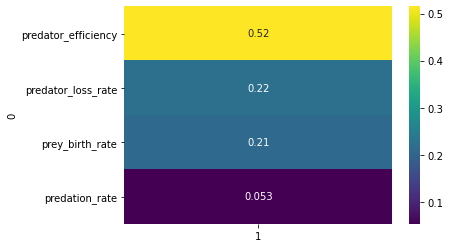

In [59]:
# use an ensemble of 100 trees and a max_features parameter of 0.6, 
# and set the analysis to regression mode

#fs = feature_scoring.get_ex_feature_scores(experiments_sobol, outcomes_sobol['prey'][:,-1], mode= RuleInductionType.REGRESSION, nr_trees = 100, max_features = 0.6)

fs, alg = feature_scoring.get_ex_feature_scores(experiments_sobol, outcomes_sobol['prey'][:,-1], mode=RuleInductionType.REGRESSION, nr_trees = 100, max_features = 0.6)

#fs.sort_values(ascending=False, by=1)

print(fs, alg)

import seaborn as sns 

sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()


The order of importance of the different input values is stable relative throughout the sobol experiments and the tree analysis

In order from greatest to least importance:
1. predator  efficiency
2. pred loss rate
3. prey birth rate
4. pred rate